# Model
We use a floquet model of spin-1/2 chain with nearest-neighbour Ising interaction. Both transverse and longitudinal fields are switched on so as to remove any conservation laws and make the system thermalise faster. We work with spins originally polarized in the x direction. Thus basis states are expressed in the computaational basis. For the parameters we refer https://arxiv.org/pdf/1609.00390. The drive is implemented in three evolution steps.


$$
U=\exp \left[-i \frac{\tau}{2} H_z\right] \exp \left[-i \tau H_x\right] \exp \left[-i \frac{\tau}{2} H_z\right],
$$
where
$$
\begin{aligned}
H_z & =\sum_{j=1}^L g \Gamma \sigma_j^z \\
H_x & =b\sum_{j=1}^{L-1} \sigma_j^x \sigma_{j+1}^x+\sum_{j=1}^L\left(h+g \sqrt{1-\Gamma^2} G_j\right) \sigma_j^x,
\end{aligned}
$$
where $\sigma_i^{\alpha=\{x, z\}}$ are Pauli spin-1/2 matrices on site $i$. We implement open boundary conditions and fix the parameters as $(g, h, \tau, b)=(0.9045,0.8090,0.8,1)$. $\{G_j\}$ are random variables drawn from a normal gaussian distribution. 



# Coherence
We study coherence evolution at stroboscopic instants of time as we tune the $\Gamma$ parameter. Coherence at a particular site is determined by calculating the off-diagonal element of the reduced density matrix at the particular site.
$$\rho^s = \mathrm{Tr}[\rho_{\bar{s}}]\\
C = \sum_{i\neq j}|\rho^{s}_{ij}|$$

C:\Users\Saakshi Porwal\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Saakshi Porwal\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Saakshi Porwal\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


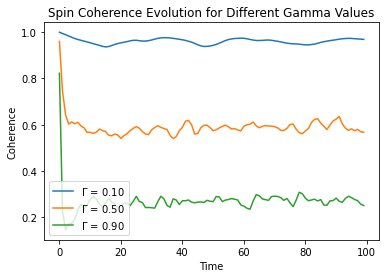

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hadamard
import time

L = 5  # Number of lattice spins
d = 100 # Number of disorder realizations
b = 1  # interaction strength for Hx

g = 0.9045
h = 0.8090
t = 0.8  # tau parameter
gamma_values = np.linspace(0.1, 0.9, 3)  # range of gamma values

# Function to calculate reduced density matrix for a single spin
def reduced_density_matrix_single_spin(wavefunction, site_index, L):
    psi = wavefunction.reshape([2] * L)
    psi = np.moveaxis(psi, site_index, 0)
    psi = psi.reshape(2, -1)
    rho_reduced = np.dot(psi, np.conjugate(psi.T))
    return rho_reduced


I = 2  # the spin we are interested in
n = 100  # number of evolution steps

# Dictionary to store coherence evolution for each gamma value
coherence_evolution = {}

# Storing the 2**L dimensional Hadamard matrix
H = hadamard(2 ** L) / np.sqrt(2 ** L)

# Action of the Z part of the Hamiltonian stored as diagonal matrix in a single vector
z = np.array([1, -1])
Dz = np.zeros(2 ** L)
for i in range(L):
    id1 = np.ones(2 ** i)
    id2 = np.ones(2 ** (L - i - 1))
    Z = np.kron(id1, np.kron(z, id2))
    Dz = Z + Dz


# Action of the X part of the Hamiltonian for different disorder realization
x = np.array([1, -1, -1, 1])
Dx = np.zeros((d, 2 ** L), dtype=complex)
X = np.zeros(2 ** L, dtype=complex)

for i in range(L - 1):
    id1 = np.ones(2 ** i)
    id2 = np.ones(2 ** (L - i - 2))
    X += np.kron(id1, np.kron(x, id2))
#X += np.kron(z, np.kron(np.ones(2 ** (L - 2)), z))  # PBC
Dx = b * np.tile(X, (d, 1))

# Main loop for different gamma values
for gamma in gamma_values:
    # Generates new disorder realizations for each gamma
    J = np.zeros((d, L))
    for i in range(d):
        J[i, :] = np.random.normal(0, 1, L)
    J = h + g * np.sqrt(1 - gamma ** 2) * J
    
    Dx_local = np.copy(Dx)
    for j in range(d):
        for i in range(L - 1):
            id1 = np.ones(2 ** i)
            id2 = np.ones(2 ** (L - i - 1))
            X = J[j, i] * np.kron(id1, np.kron(z, id2))
            Dx_local[j, :] = X + Dx_local[j, :]
            
    Dz_exp = np.exp(-1j * (g * gamma) * Dz * t / 2)
    Dx_exp = np.exp(-1j * Dx_local * t)
    C = np.zeros((d, n), dtype=complex)

    for j in range(d):
        v = np.zeros(2 ** L, dtype=complex)
        v[3] = 1  # particular basis state
        v = np.dot(H, v)

        for i in range(n):
            v = Dz_exp * v
            v = np.dot(H, v)
            v = Dx_exp[j, :] * v
            v = np.dot(H, v)
            v = Dz_exp * v
            u = reduced_density_matrix_single_spin(v, I, L)

            C[j, i] = 2 * np.abs(u[0, 1])

    Ci = np.sum(C, axis=0) / d
    coherence_evolution[gamma] = Ci

# Plotting coherence evolution for each gamma value
for gamma in gamma_values:
    plt.plot(np.arange(n), coherence_evolution[gamma], label=f'$\Gamma$ = {gamma:.2f}')

plt.xlabel("Time")
plt.ylabel("Coherence")
plt.title("Spin Coherence Evolution for Different Gamma Values")
plt.legend(loc='best')
plt.show()


# Entanglement Negativity
Next we try to quantify how the entanglement of a particular subsystem varies with time with the rest of the spins serving as the bath. For this we evaluate entanglement negativity with time for subsystem with two spins which were initially prepared in a bell state.

$$E(\rho) = \frac{||\rho^{T_a}|| -1}{2}$$

where $\rho^{T_a}$ is the partial transpose with respect to subsystem A and $\rho$ is the reduced density matrix of the two spin system prepared in the mixed state. 

C:\Users\Saakshi Porwal\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


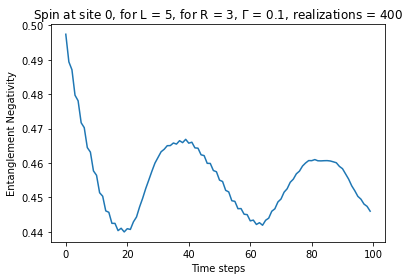

In [5]:
# calculating entanglement negativity evolution

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hadamard
from numpy.linalg import eigvals



L = 5 # Number of lattice spins
d = 400 # Number of disorder realizations
J = np.zeros((d, L)) #disorder realizations
b = 1  #interaction parameter for Hx

g = 0.9045
h = 0.8090
t = 0.8  # tau parameter
T = 0.1 # gamma paramter

for i in range(d):
    J[i,:] = np.random.normal(0,1,L)

J = h + g*np.sqrt(1 - T**2)*J

# Storing the 2**L dimensional Hadamard matrix
H = hadamard(2**L)/np.sqrt(2**L)


# Action of the Z part of the Hamiltonian
z = np.array([1,-1])
Dz = np.zeros(2**L)
for i in range(L):
    id1 = np.ones(2**(i))
    id2 = np.ones(2**(L- i -1))
    Z = np.kron(id1, np.kron(z, id2))
    Dz = Z + Dz
Dz = np.exp(-1j*(g*T)*Dz*t/2)


# Action of the X part of the Hamiltonian for different disorder realization
x = np.array([1, -1, -1, 1])
Dx = np.zeros((d, 2**L), dtype = complex)
X = np.zeros(2**L, dtype = complex)

for i in range(L-1):
    id1 = np.ones(2**(i))
    id2 = np.ones(2**(L- i -2))
    X += np.kron(id1, np.kron(x, id2))
#X += np.kron(z, np.kron(np.ones(2**(L-2)), z))   #PBC
Dx = b*np.tile(X, (d,1))

for j in range(d):
    for i in range(L-1):
        id1 = np.ones(2**(i))
        id2 = np.ones(2**(L- i -1))
        X = J[j,i]*np.kron(id1, np.kron(z, id2))
        Dx[j,:] = X + Dx[j,:]

Dx = np.exp(-1j*Dx*t)


# Function to calculate reduced density matrix for two spins
def reduced_density_matrix_two_spins(wavefunction, site_index1, site_index2, L):
    psi = wavefunction.reshape([2] * L)
    psi = np.moveaxis(psi, [site_index1, site_index2], [0, 1])    
    psi = psi.reshape(4, -1)    
    rho_reduced = np.dot(psi, np.conjugate(psi.T))
    
    return rho_reduced

# position of the entangled spins at I and I+R+1
I = 0
R = 3

n = 100 # nu7mber of evolution of steps

# specifying the bell pair initial state for spins located at I and I+R+1
k2 = 2**(L-I-1) + 2**(L-I-R-2)
state = np.zeros(2**L, dtype = complex)
state[0] = 1
state[k2] = 1

# store the entanglement negativity
entanglement_negativity = np.zeros((d, n), dtype = complex)

for j in range(d):
    v = state/np.linalg.norm(state) 
    v = np.dot(H,v)
    
    for i in range(n):     
        v = Dz*v 
        v = np.dot(H,v)
        v = Dx[j,:]*v
        v = np.dot(H,v)
        v = Dz*v 
        rho = reduced_density_matrix_two_spins(v,I,I+R+1,L)
        # Calculates partial transpose with respect to first spin
        rho = rho.reshape(2, 2, 2, 2).swapaxes(1, 3).reshape(4, 4)
        eigenvalues = eigvals(rho)
        
        entanglement_negativity[j,i] = np.sum(np.abs(eigenvalues[eigenvalues < 0]))

entanglement_negativity = np.sum(entanglement_negativity, axis = 0)/d
plt.plot(np.arange(n), entanglement_negativity)
plt.xlabel('Time steps')
plt.ylabel('Entanglement Negativity')
plt.title("Spin at site " +str(I)+", for L = " +str(L)+", for R = " +str(R) +", $\Gamma$ = " +str(T)+", realizations = " +str(d))
plt.show()



        
       


